# ANN Notebook part 1 - Classification
## This notebook explores how to create, train \& optimize Artificial Neural Networks for classification 
#### ...using the cleaned data insights pharmacy data produced in the data_cleaning_insights notebook

### Structure:
1. Preprocessing:
    * Choosing features for classification
    * Data visualization
    * Splitting data into training, validation \& test data sets
    * Transforming the data
2. Classification using neural networks
    * Model Building, training \& evaluation + making predictions on validation data
    * Hyperparameter optimization: Finding the optimal paramters
    * Feature ranking: Finding the most important features
    * Evaluating the trained \& optimized model on the test data



### Goal:
Using the other features, we are going to predict the ATC5 Code (i.e. medicine type) for each data point. There are only 3 kinds in this dataset, making it easier. To make it easier still, and make it into a binary classification problem, we will consier only 2 out of the 3 medicine types


******************
$\textit{Authors:}$ Nikolaj Krebs \& Simon Guldager \
$\textit{Date:}$ 18-09-2024

In [15]:
#pip install tensorflow

In [16]:
#pip install scikeras


In [17]:
#pip install keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import confusion_matrix and classification_report for model evaluation
from sklearn.metrics import accuracy_score
# Import StandardScaler for feature scaling
from sklearn.preprocessing import StandardScaler, QuantileTransformer
# Import train_test_split for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# Import permutation_importance for calculating feature importance  
from sklearn.inspection import permutation_importance


### Tensorflow and Keras imports ###

# Import TensorFlow for machine learning
import tensorflow as tf
# Import Keras for high-level neural networks API
from tensorflow import keras
# Import Dense and Activation layers for neural network architecture
from tensorflow.keras.layers import Dense, Activation
# Import Sequential for linear stacking of layers
from keras.models import Sequential
# Import KerasClassifier to make Keras models compatible with scikit-learn
from scikeras.wrappers import KerasClassifier


# set print options for pandas
pd.set_option('display.max_columns', None)

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler
## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

Useful functions for plotting and evaluating classification results

In [2]:
def plot_classificiation_results(history):

    # make a list of the train and val metrics
    metrics = list(history.history.keys())
    
    # make lists of train and val metrics
    val_metrics = [entry for entry in metrics if entry.startswith('val_')]
    train_metrics = [entry for entry in metrics if not entry.startswith('val_')]

    # the number of metrics to plot
    Nmetrics = len(val_metrics)
    width = 6 * Nmetrics

    fig, ax = plt.subplots(ncols = Nmetrics, figsize=(width, 6))

    # plot the train and val results for each metric
    for i, axx in enumerate(ax):
        ax[i].plot(history.history[train_metrics[i]], label='train', alpha = 0.7)  
        ax[i].plot(history.history[val_metrics[i]], label='validation', alpha = 0.7)
        ax[i].set_ylabel(f'{train_metrics[i].capitalize()}')
        ax[i].set_xlabel('Epoch')
        ax[i].legend(loc='best')
    fig.tight_layout()
    return fig, ax 

def evaluate_binary_classification_results(model, X_train, y_train, X_val, y_val, X_test = None, y_test = None,\
                                           metrics = [accuracy_score], metric_names = ['Accuracy']):
    
    # make predictions
    y_pred_train = model.predict(X_train, verbose = 0)   
    y_pred_val = model.predict(X_val, verbose = 0)

    # if test data is provided, make predictions
    if X_test is not None and y_test is not None:
        y_pred_test =  model.predict(X_test, verbose = 0)

    # calculate metrics
    for metric, metric_name in zip(metrics, metric_names):
        metric(y_train, y_pred_train.round())
        print(f'{metric_name} on training data: {metric(y_train, y_pred_train.round()):.3f}')
        print(f'{metric_name} on validation data: {metric(y_val, y_pred_val.round()):.3f}')
        if X_test is not None and y_test is not None:
            print(f'{metric_name} on test data: {metric(y_test, y_pred_test.round()):.3f}')
    return

Load the sales insight data. 

In [3]:
df = pd.read_csv('data_processed/sales_insights_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7282 entries, 0 to 7281
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Account Description      7282 non-null   object 
 1   Size                     7282 non-null   object 
 2   Size Numeric             7282 non-null   float64
 3   Strength (mg)            7282 non-null   float64
 4   WHO ATC 5 Code           7282 non-null   object 
 5   Volume                   7282 non-null   float64
 6   Value                    7282 non-null   float64
 7   Year Month (after 2000)  7282 non-null   float64
 8   Year (after 2000)        7282 non-null   float64
 9   Month                    7282 non-null   float64
 10  Region_Færøerne          7282 non-null   bool   
 11  Region_Hovedstaden       7282 non-null   bool   
 12  Region_Midtjylland       7282 non-null   bool   
 13  Region_Nordjylland       7282 non-null   bool   
 14  Region_Sjælland         

Let's have a look at the WHO ATC 5 values

In [4]:
df['WHO ATC 5 Code'].value_counts()

WHO ATC 5 Code
L04AC05    3713
L04AB02    2259
L04AB05    1310
Name: count, dtype: int64

In [5]:
# set the target column for the classification
target_col = 'WHO ATC 5 Code'

# represent the ATC code with a number (if not already done)
if df['WHO ATC 5 Code'].dtype == 'object':
    atc_code_rep = {'L04AC05': 0, 'L04AB02': 1, 'L04AB05': 2, }
    df['WHO ATC 5 Code'] = df['WHO ATC 5 Code'].map(atc_code_rep).astype(int)

df['WHO ATC 5 Code'].value_counts()

WHO ATC 5 Code
0    3713
1    2259
2    1310
Name: count, dtype: int64

It's sort of cheating to include the product columns (same for the strength and size columns), so we'll not. Let's make a list with them

In [6]:
# find all columns starting with 'Product'
product_columns = [col for col in df.columns if 'Product' in col]
product_columns

['Product_Cimzia',
 'Product_Inflectra',
 'Product_Remicade',
 'Product_Remsima',
 'Product_Stelara',
 'Product_Zessly']

Let's decide the columns to use for classification

In [7]:
# choose columns to drop from the dataset
num_cols_to_drop = ['Year Month (after 2000)', 'Strength (mg)', 'Size Numeric']
# add product columns to the list of columns to drop
num_cols_to_drop.extend(product_columns)

# get all numerical columns
num_cols = list(df.select_dtypes(include=['float', 'bool']).columns)

# remove columns to drop from the list of numerical columns
cols_to_use_for_classification = [col for col in num_cols if col not in num_cols_to_drop]

cols_to_use_for_classification

['Volume',
 'Value',
 'Year (after 2000)',
 'Month',
 'Region_Færøerne',
 'Region_Hovedstaden',
 'Region_Midtjylland',
 'Region_Nordjylland',
 'Region_Sjælland',
 'Region_Syddanmark']

# Correlation Matrix

Let's compute the correlation matrix for the features to use for classification along with the target column

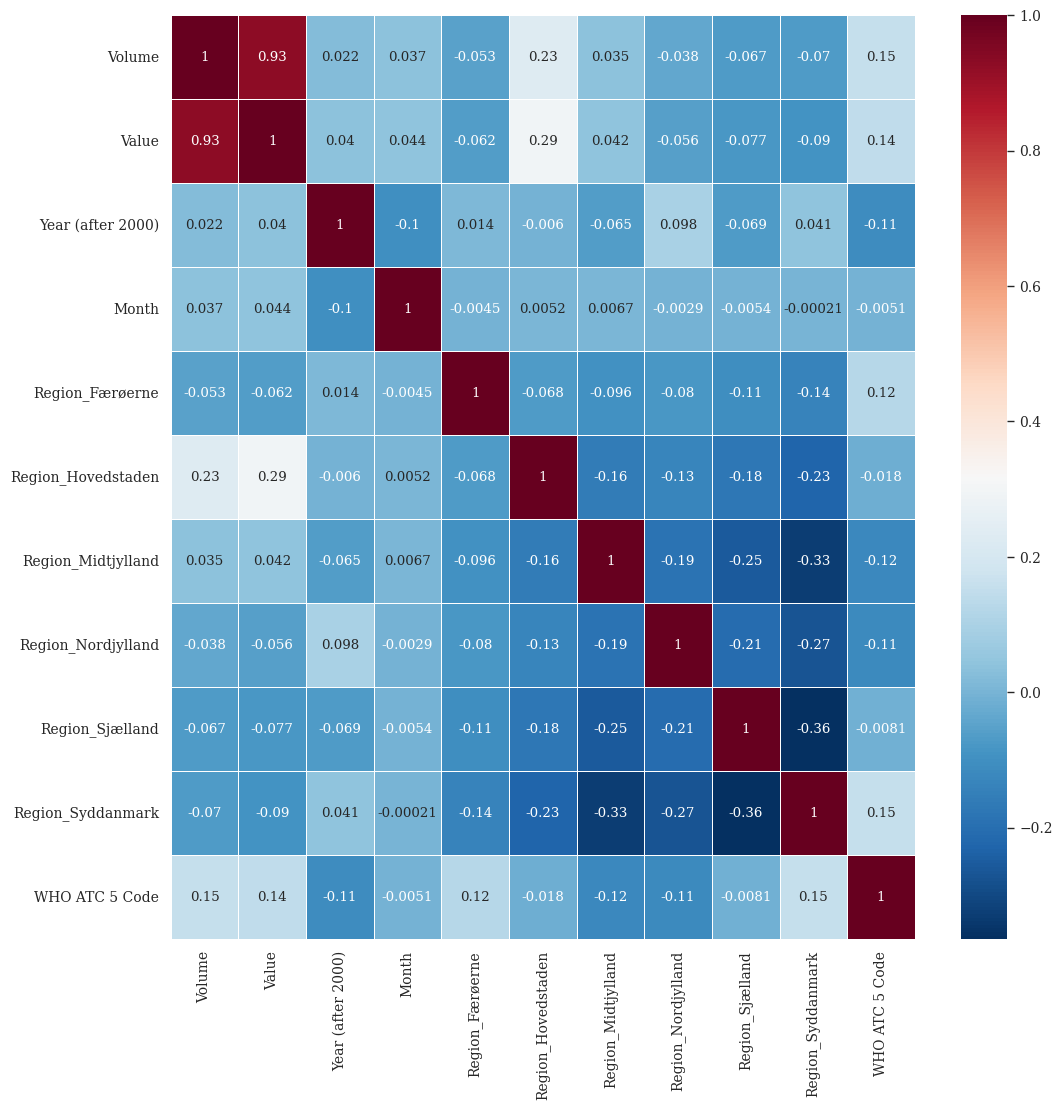

In [8]:
#### Compute the pairwise Pearson correlation matrix for df.

# The Pearson correlation coefficient measures the linear relationship between two variables.
# Its value ranges from -1 to 1, where:
# - 1 implies a perfect positive linear relationship,
# - -1 implies a perfect negative linear relationship, and
# - 0 implies no linear relationship.

corr = df[cols_to_use_for_classification + [target_col]].corr(method='pearson')

# Create a new figure and axis with a specified size.
# Adjust the figsize values to change the size of each cell in the heatmap.
fig, ax = plt.subplots(figsize=(12, 12))

# Create a heatmap using Seaborn.
# - `corr`: The computed correlation matrix.
# - `xticklabels` & `yticklabels`: Use the columns of the correlation matrix for labeling the x and y axis respectively.
#   blue represents positive correlations and red represents negative correlations.
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax);

## ANN - Classification
The following section will present the creation of an ANN that is used for classification.

We will try an solve the same issues as presented in the last exercise.
1. Start by defining the independent variables and the dependent variable
2. Split the dataset into test and train (this is done in the same way as any other method)
3. Creation of ANN model - including input layer, hidden layers, and output layer
4. Then train (fit) the model
5. Evaluate results
6. Investigate optimization of the model (Hyperparameter tuning)

### Data data transformation \& splitting

In [9]:
# Split the dataset into features and target variable
df_X = df[cols_to_use_for_classification]
df_y = pd.DataFrame(data = df[target_col], columns = [target_col])

# For simplicity, we will only consider the y=0 and y=1 classes
df_X = df_X[df_y[target_col].isin([0, 1])].reset_index(drop=True)
df_y = df_y[df_y[target_col].isin([0, 1])].reset_index(drop=True)

# Initialize the StandardScaler object
# StandardScaler standardizes the dataset by setting the mean to 0 and variance to 1
scaler = StandardScaler()

# Fit and transform the independent data features
X = scaler.fit_transform(df_X)
y = df_y.values.ravel()

print("Independent variables:",cols_to_use_for_classification)
print("Dependent variable:",target_col)
print("Shape of independent features:", X.shape)
print("Shape of target variable:", y.shape)

Independent variables: ['Volume', 'Value', 'Year (after 2000)', 'Month', 'Region_Færøerne', 'Region_Hovedstaden', 'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland', 'Region_Syddanmark']
Dependent variable: WHO ATC 5 Code
Shape of independent features: (5972, 10)
Shape of target variable: (5972,)


In [10]:
# y takes on two values: 0 and 1 (binary classification), respectively representing the two classes
y

array([0, 0, 0, ..., 1, 1, 1])

In [11]:
# Set the fraction of data to be used for test data
test_size = 0.15

## Split training data into training-validation and test data for classification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Split training data into training and validation data for classification
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=42)


print('X_train.shape:',X_train.shape)
print('X_val.shape:',X_val.shape)
print('X_test.shape:',X_test.shape)
print('y_train.shape:',y_train.shape)
print('y_val.shape:',y_val.shape)
print('y_test.shape:',y_test.shape)

X_train.shape: (4314, 10)
X_val.shape: (762, 10)
X_test.shape: (896, 10)
y_train.shape: (4314,)
y_val.shape: (762,)
y_test.shape: (896,)


## Building a neural network

#### Step 1: Create the model

In [13]:
### Create an instance of a Keras Sequential model.
# Sequential models are appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = keras.models.Sequential()


### Add layers to the model.
# Add an Input layer to the model.
# The 'shape' argument specifies the shape of the input data, which here matches the number of features in X_train.
model.add(keras.layers.Input(shape=X_train.shape[1]))

# Add the first hidden layer with e.g. 15 units and ReLU (Rectified Linear Unit) activation function.
# ReLU activation function replaces all negative values in the output with zero.
model.add(keras.layers.Dense(15, activation='relu'))

# Add the second hidden layer with e.g. 20 units and ReLU activation function.
model.add(keras.layers.Dense(20, activation='relu'))

# Add the output layer with a single unit and a sigmoid activation function.
# The sigmoid function is often used in the output layer of a binary classification problem.
# It squashes the output to lie in the range of 0 to 1, which can be interpreted as probabilities.
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                165       
                                                                 
 dense_5 (Dense)             (None, 20)                320       
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 506 (1.98 KB)
Trainable params: 506 (1.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Step 2: Compile the model

In [14]:
# Compile the model with the necessary attributes.
# - loss function: 'binary_crossentropy' is commonly used for binary classification problems.
# - optimizer: 'adam' is a popular optimization algorithm that is an extension of stochastic gradient descent.
# - learning rate: how quickly the model updates it weights. A large learning rate causes the model to adapt more quickly,
#                  but at the cost of stability
# - metrics: 'accuracy' is used to evaluate the model (but there are many good choices).

# Compile the model with the necessary attributes and the default learning rate.
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy',])

#### Step 3: Fit the model to the training data

In [15]:
# batch_size: the number of samples that will be propagated through the network. a smaller batch size will take longer to train,
#             but will be more accurate. A larger batch size will train faster, but will be less accurate.
# epochs: the number of times the model will cycle through the data. A larger number of epochs will take longer to train,

history = model.fit(X_train, y_train, batch_size=128, epochs=150, validation_data=(X_val, y_val), verbose=1)

Epoch 1/150
34/34 [==============================] - 1s 11ms/step - loss: 0.6516 - accuracy: 0.6528 - val_loss: 0.6255 - val_accuracy: 0.6942
Epoch 2/150
34/34 [==============================] - 0s 3ms/step - loss: 0.5956 - accuracy: 0.7223 - val_loss: 0.5714 - val_accuracy: 0.7297
Epoch 3/150
34/34 [==============================] - 0s 3ms/step - loss: 0.5500 - accuracy: 0.7510 - val_loss: 0.5240 - val_accuracy: 0.7533
Epoch 4/150
34/34 [==============================] - 0s 3ms/step - loss: 0.5082 - accuracy: 0.7758 - val_loss: 0.4803 - val_accuracy: 0.7822
Epoch 5/150
34/34 [==============================] - 0s 2ms/step - loss: 0.4695 - accuracy: 0.7907 - val_loss: 0.4371 - val_accuracy: 0.8241
Epoch 6/150
34/34 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8261 - val_loss: 0.4034 - val_accuracy: 0.8333
Epoch 7/150
34/34 [==============================] - 0s 3ms/step - loss: 0.4098 - accuracy: 0.8370 - val_loss: 0.3764 - val_accuracy: 0.8556
Epoch 8/150


#### Step 4: Evaluate the model performance on the training and validation data

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


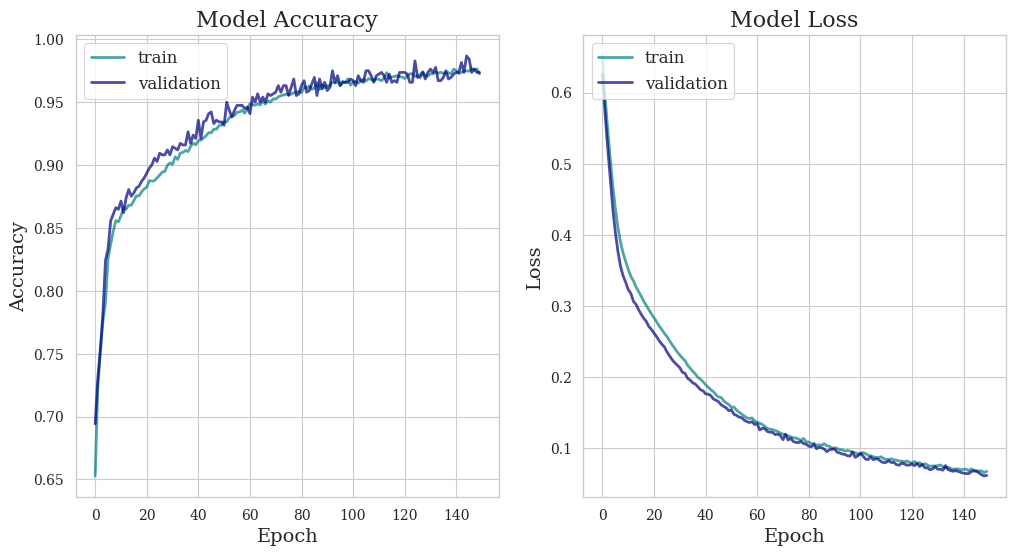

In [16]:
# Print the keys available in the 'history' object.
# This usually includes things like 'loss' and the metrics you chose to monitor, which are 'acc' and 'AUC' in this case.
print(history.history.keys())

fig, ax = plt.subplots(ncols = 2, figsize=(12, 6))

ax[0].plot(history.history['accuracy'], label='train', alpha = 0.7)  
ax[0].plot(history.history['val_accuracy'], label='validation', alpha = 0.7)
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

ax[1].plot(history.history['loss'], label='train', alpha = 0.7)
ax[1].plot(history.history['val_loss'], label='validation', alpha = 0.7)
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left');

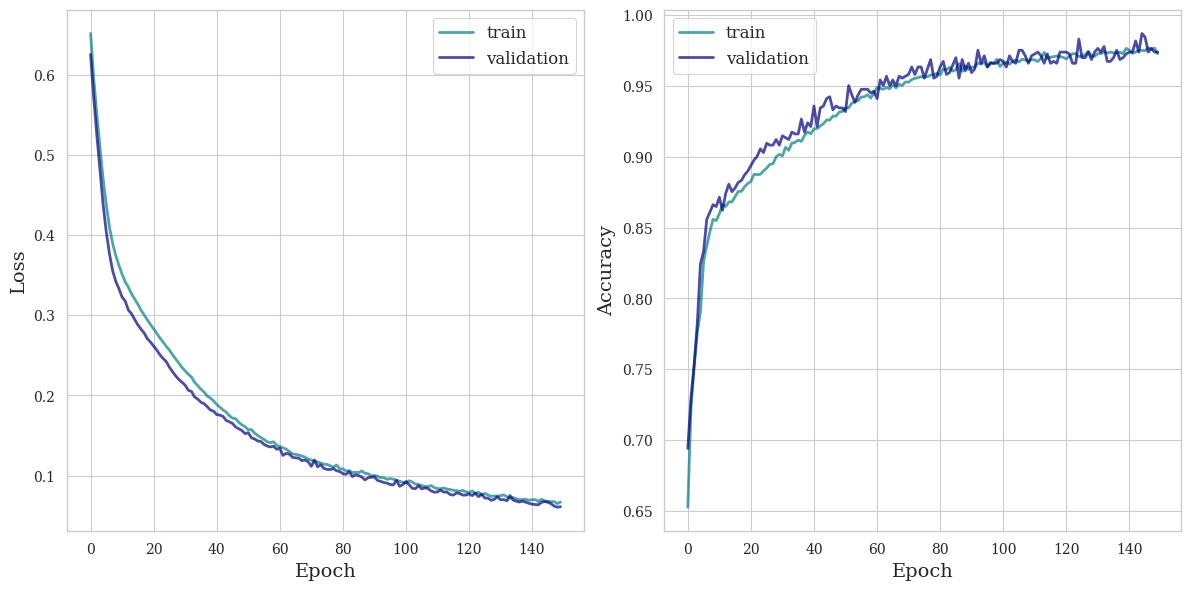

In [17]:
# the code for plotting is collected in this function for convenience
plot_classificiation_results(history);

Let's Make predictions on the train and validation data using the trained model

In [18]:
# Generate predictions using the trained model on the test data
y_pred_train = model.predict(X_train, verbose = 0)   
y_pred_val = model.predict(X_val, verbose = 0)

print(f'Accuracy on training data: {accuracy_score(y_train, y_pred_train.round()):.3f}')
print(f'Accuracy on validation data: {accuracy_score(y_val, y_pred_val.round()):.3f}')


Accuracy on training data: 0.975
Accuracy on validation data: 0.974


In [19]:
# the prediction code above is collected in the function below for convience 
evaluate_binary_classification_results(model, X_train, y_train, X_val, y_val)

Accuracy on training data: 0.975
Accuracy on validation data: 0.974


#### As is clear from the figures above, the model keeps improving on both the training and validation data. This implies that it hasn't stopped learning, i.e. we should train it for longer or increase the complexity (no. of parameters in the model) to enable it to learn more complex patterns.

We are going to increase the number of epochs in the following, but to avoid overtraining, we are going to use $\textit{early stopping}$ to stop the traning if the model hasn't improved on average for a given number of epochs.

............................


build \& compile!

In [114]:
# Create an instance of a Keras Sequential model.
# Sequential models are appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = keras.models.Sequential()

# Add an Input layer to the model.
# The 'shape' argument specifies the shape of the input data, which here matches the number of features in X_train.
model.add(keras.layers.Input(shape=[X_train.shape[1]]))

# Add the first hidden layer with 30 units and ReLU (Rectified Linear Unit) activation function.
# ReLU activation function replaces all negative values in the output with zero.

model.add(keras.layers.Dense(15, activation='relu'))
# Add the second hidden layer with e.g. 20 units and ReLU activation function.
model.add(keras.layers.Dense(20, activation='relu'))


# Add the output layer with a single unit and a sigmoid activation function.
# The sigmoid function is often used in the output layer of a binary classification problem.
# It squashes the output to lie in the range of 0 to 1, which can be interpreted as probabilities.
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 15)                165       
                                                                 
 dense_241 (Dense)           (None, 20)                320       
                                                                 
 dense_242 (Dense)           (None, 1)                 21        
                                                                 
Total params: 506 (1.98 KB)
Trainable params: 506 (1.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


... train for many epochs with early stopping

In [21]:
# set the number of epochs
epochs = 450
# set the patience for early stopping, i.e. the number of epochs with no improvement after which training will be stopped
patience = 50
# set the batch size
batch_size = 128
# should the model be verbose? (i.e. output the training progress) 0 = no, 1 = yes
verbose = 0

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), \
                    callbacks = [keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = patience)], verbose = verbose)

... It's still learning!. Also, there is no sign of overtraining (validation loss going up). Both of which suggest that we should increase the number of epochs even further and/or increase the complexity of the model

ALSO: The 'wiggliness' of the validation accuracies can be reduced by reducing the learning rate, but it will then take more epochs to train the model 

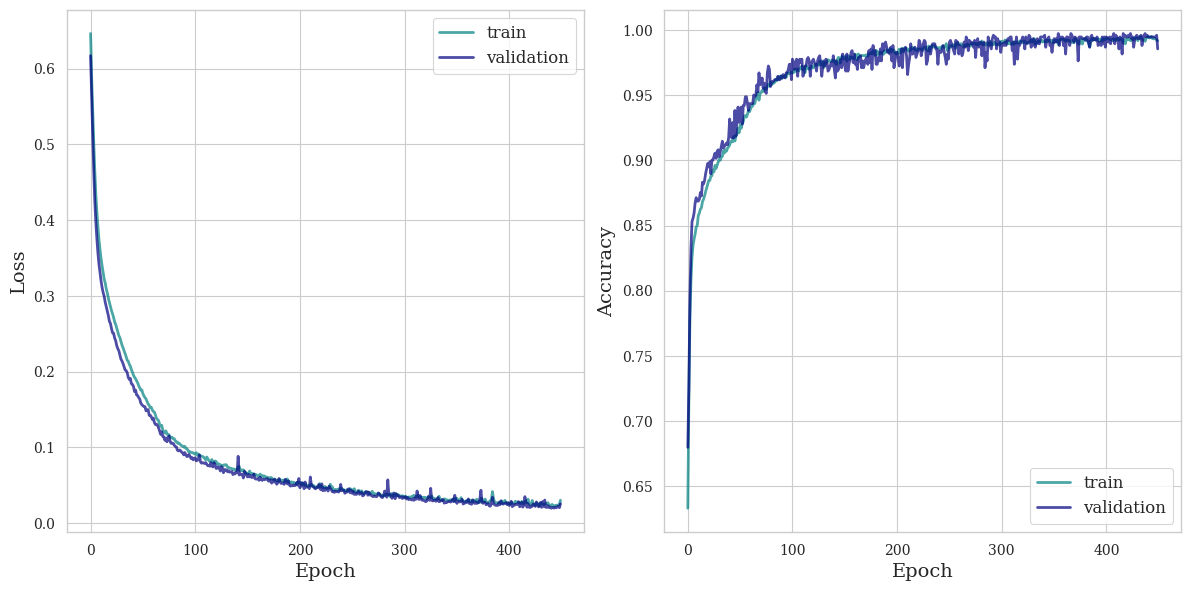

In [23]:
plot_classificiation_results(history);

... evaluate performance. The observation that the model performs as well on the validation data as on the training data is a strong indication that overtrained has not occurred

In [24]:
evaluate_binary_classification_results(model, X_train, y_train, X_val, y_val)

Accuracy on training data: 0.989
Accuracy on validation data: 0.986


## Hyperparameter tuning with Grid Search

### To further increase the performance of the ANN we will look into hyperparameters and see what we can change to increase accuracy. 

.................................

Most important hyperparameters:
* Architehture of the model (Number of layers \& number of neurons in each layer)
* Learning rate
* Batch size
* Epochs (but we can avoid tuning this by using early stopping)


Advanced hyperparameter tuning:
* Kernel initializaiton \& regularization of each layer
* Adaptive learning rate
* Batch normalization
* Activation functions

................................

In the following, we will

1. Create a function that creates an ANN model
2. Create a dictionary that contains all hyperparameters we wish to investigate
3. Conduct Grid search to find optimal parameters
4. Evaluate the performance of the optimal parameter model
5. Create a model using optimal parameters, train it and evaluate it on the train and validation data
6. Once we have a trained and optimized model - $\textbf{and only then!}$ - we will evaluate its performance on the test data test

****************

1. Make function that creates a model once given a list of layer sizes and a learning rate

In [25]:
# Define a function named 'create_model' that takes 'layers' and 'learning_rate' as parameters.
def create_model(layers, learning_rate):
    # Initialize an empty Sequential model.
    model = Sequential()

    # Loop through the list of layers specified in the 'layers' parameter.
    # The 'enumerate' function returns both the index 'i' and the value 'nodes' of each layer.
    for i, nodes in enumerate(layers):
        # If it's the first layer (i == 0), add an input dimension.
        if i == 0:
            model.add(keras.layers.Dense(nodes, input_dim = X_train.shape[1], activation='relu'))
        # For subsequent layers, no need to specify the input dimension.
        else:
            model.add(keras.layers.Dense(nodes, activation='relu'))

    # Add the output layer with a single unit (binary classification). 
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    print(model.summary())

    # Compile the model with the 'adam' optimizer and 'binary_crossentropy' loss function.
    # Metrics used for evaluation is accuracy.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Return the compiled model.
    return model

2. Choose the layer sizes you want to test (it has been written so that learning rate, batch size and epochs can easily be included, too)

In [41]:
# Specify different architectures (layer configurations) and activation functions for the grid search.
layers = [[20, 20, 20], [20, 20, 20, 20]]

# set the leaning rates to use in grid search (default is 0.001)
learning_rates = [0.001]

# set the batch size to use in grid search
batch_sizes=[128]

# set the number of epochs to use in grid search (default is 250)
epochs = [500]

# Create a dictionary that holds the different hyperparameters and their possible values.
param_grid = dict(layers=layers, learning_rate=learning_rates, batch_size=batch_sizes, epochs=epochs)


Use the KerasClassifier to make the model compatible with the Sklearn grid search function, and perform grid search

$\textbf{NB:}$ The number of cv_splits should generally be higher than 3 (like e.g. 5); we do it here do reduce computation time

In [44]:
# Create a KerasClassifier object wrapping the 'create_model' function.
# Here 'verbose=0' suppresses the output during the training process.
# Default activation function is set to 'relu', and default layers set to 20 (this is somewhat unconventional,
# typically 'layers' would be a list indicating neurons per layer).

# The 'model' object is now a KerasClassifier object that can be used in the GridSearchCV function.q
# The keras classifier must take the same parameters as the create_model function (ie. layers and learning rate)
model = KerasClassifier(model=create_model, verbose=0, learning_rate=0.001, layers=[20],)

# Set the number of cross-validation splits to use in the GridSearchCV function.
cv_splits = 3

# Use GridSearchCV to search through the hyperparameter space.
# The estimator is the KerasClassifier, and the parameter grid is specified by 'param_grid'.
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', \
        cv=cv_splits, verbose=3).fit(X_train, y_train, callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=50)])


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END batch_size=128, epochs=500, layers=[20, 20, 20], learning_rate=0.001;, score=0.992 total time=  19.0s
[CV 2/3] END batch_size=128, epochs=500, layers=[20, 20, 20], learning_rate=0.001;, score=0.989 total time=  19.3s
[CV 3/3] END batch_size=128, epochs=500, layers=[20, 20, 20], learning_rate=0.001;, score=0.990 total time=  18.3s
[CV 1/3] END batch_size=128, epochs=500, layers=[20, 20, 20, 20], learning_rate=0.001;, score=0.988 total time=  19.9s
[CV 2/3] END batch_size=128, epochs=500, layers=[20, 20, 20, 20], learning_rate=0.001;, score=0.990 total time=  19.7s
[CV 3/3] END batch_size=128, epochs=500, layers=[20, 20, 20, 20], learning_rate=0.001;, score=0.983 total time=  20.5s


... evaluate best model

In [45]:
best_params = grid.best_params_

print(f'Best accuracy: {grid.best_score_}')
print(f'Best parameters: {best_params}')

# Retrieve the best score and best parameters from the grid search
[grid.best_score_, grid.best_params_];


Best accuracy: 0.9900324524802967
Best parameters: {'batch_size': 128, 'epochs': 500, 'layers': [20, 20, 20], 'learning_rate': 0.001}


... train model with 'optimized' (we haven't been nearly thorough enough!) parameters

In [52]:
# create model with optimized parameters
model = create_model(learning_rate=best_params['learning_rate'], layers=best_params['layers'])
history = model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], \
                    validation_data=(X_val, y_val),\
                     verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=50)])

In [53]:
evaluate_binary_classification_results(model, X_train, y_train, X_val, y_val)

Accuracy on training data: 0.996
Accuracy on validation data: 0.996


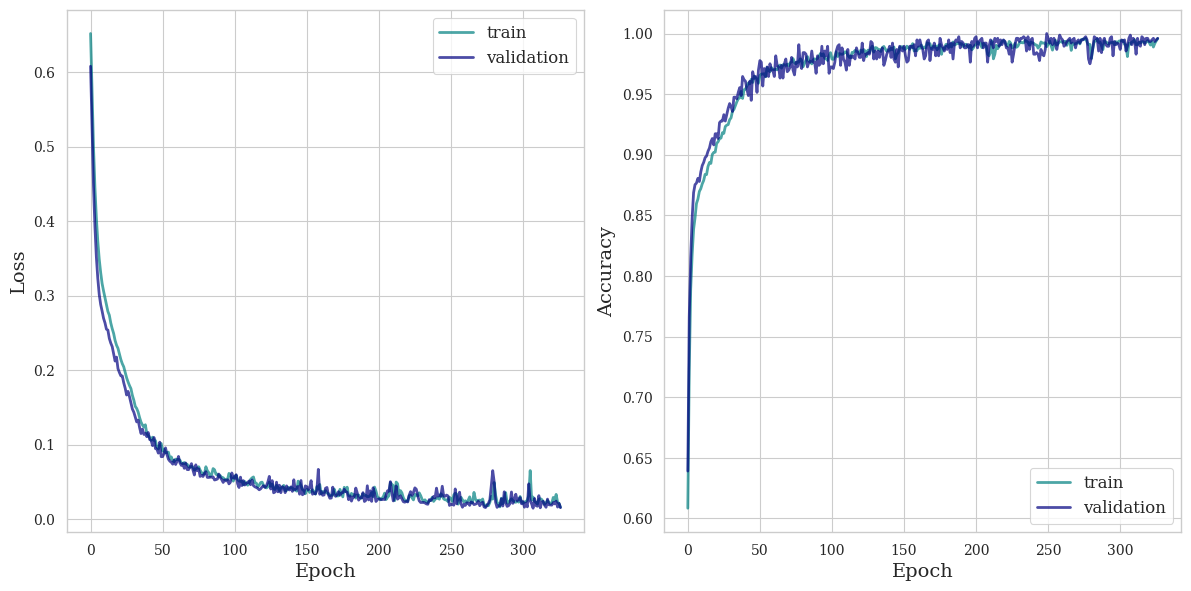

In [54]:
plot_classificiation_results(history);

### Feature ranking: Which features are the most important?

One way of doing this is by permutation importance - the rows of each column are shuffled, and we record the impact that this has on model performance. If it doesn't change the results much, the corresponding feature isn't very important \& vice versa

In [92]:
# create skelarn compatible model with optimized parameters
model = KerasClassifier(model=create_model, verbose=0, learning_rate=best_params['learning_rate'], layers=best_params['layers'],)
# train it
model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], \
          validation_data=(X_val, y_val), verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=50)])
# calculate the permutation importance
feature_importance = permutation_importance(model, X_train, y_train, scoring='accuracy', \
                        n_repeats=10, n_jobs=1, random_state=42, sample_weight=None, max_samples=1.0);


By ranking the feature importance as below, we can see which features are important, and which ones might be dropped without hurting performance

In [111]:
feature_importance_means = feature_importance.importances_mean

# sort the feature importance means and the corresponding features
feature_importance_means_sorted, features_sorted = zip(*sorted(zip(feature_importance_means, cols_to_use_for_classification)),)

# reverse the order of the sorted features and feature importance means to get the most important features first
feature_importance_means_sorted = feature_importance_means_sorted[::-1]
features_sorted = features_sorted[::-1]

print(f'Relative feature importance:\n')
for i, feature in enumerate(features_sorted):
    print(f'{feature}: {feature_importance_means_sorted[i]:.3f}')

Relative feature importance:

Volume: 0.530
Value: 0.156
Region_Syddanmark: 0.089
Region_Sjælland: 0.081
Region_Midtjylland: 0.076
Region_Nordjylland: 0.070
Region_Hovedstaden: 0.032
Year (after 2000): 0.024
Region_Færøerne: 0.011
Month: 0.003


Finally, now we have built, optimized and trained our model, we evaluate its performance on the so far unseen test data


In [112]:
evaluate_binary_classification_results(model, X_train, y_train, X_val, y_val, X_test, y_test)

Accuracy on training data: 0.997
Accuracy on validation data: 0.995
Accuracy on test data: 0.996


*************************************

# Exercises

### Exercise 1: 

Go through this notebook step by step and make sure you understand what we do and why

### Exercise 2: 

Looking at the feature importance results above, drop at least one unimportant feature and retrain the first model (the simple 2 layer one). Was the model performance affected?

### Exercise 3:

1. Choose your favorite combination of hyperparameters - train and evaluate your model. Can you do better than our previous model in terms of the accuracy on the train and validation data?
2. Use hyperparameter choosing to optimize one or more hyperparameters. Did the performance improve?


### Exercise 4:

Include the 3rd medicine group in the ATC 5 column and see if you can accurately classify all 3 classes!

Important things to account for:
- you must change the loss function from binary crossentropy to e.g. categorical crossentropy or another multi-classification loss function
- you must change the format of the target variable y to now have the shape [Npoints, Ncategories]. A row in y thus looks like either [0,0,1], [0,1,0] or [1,0,0], where 1 corresponds to the category that the given point belongs to.
- accuracy is not always the best metric for multi-classification problems. Have a look at other metrics like e.g. the f1 score

